# What drives the price of a used car?

## Questions Asked

Questions for this exercise appeared in the following quasi-random permutations
- What drives the price of a used car?
    - What do consumers value in a used car?
    - Understand what factors make a car more or less expensive
    - We are tasked with identifying key drivers for used car prices
- Used-car dealers are interested in fine-tuning their inventory

The above can be summarized into 2 categories
- What we want to know
    - What attributes of a car determine its price
- Why we want to know it
    - Dealers want to *fine tune* their inventory
        - But what does fine tune their inventory mean?
        - Fine tune it for.. what?

## Overview

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

## Deliverables

After understanding, preparing, and modeling your data, write up a basic report that details your primary findings. Your audience for this report is a group of used car dealers interested in fine-tuning their inventory.

## Grading

**Modeling**
- Use of multiple regression models
- Cross-validation of models
- Grid search hyperparameters
- Appropriate interpretation of coefficients in models
- Appropriate interpretation of evaluation metric
- Clear identification of evaluation metric
- Clear rationale for use of given evaluation metric

**Findings**
- Clearly stated business understanding of problem
- Clean and organized notebook with data cleaning
- Correct and concise interpretation of descriptive and inferential statistics
- Clearly stated findings in their own section with actionable items highlighted in appropriate language for a non-technical audience
- Next steps and recommendations

## The CRISP-DM Framework

### Intro and Diagram

To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

<center>
    <img src = images/crisp.png width = 35%/>
</center>

### CRISP-DM Tasks

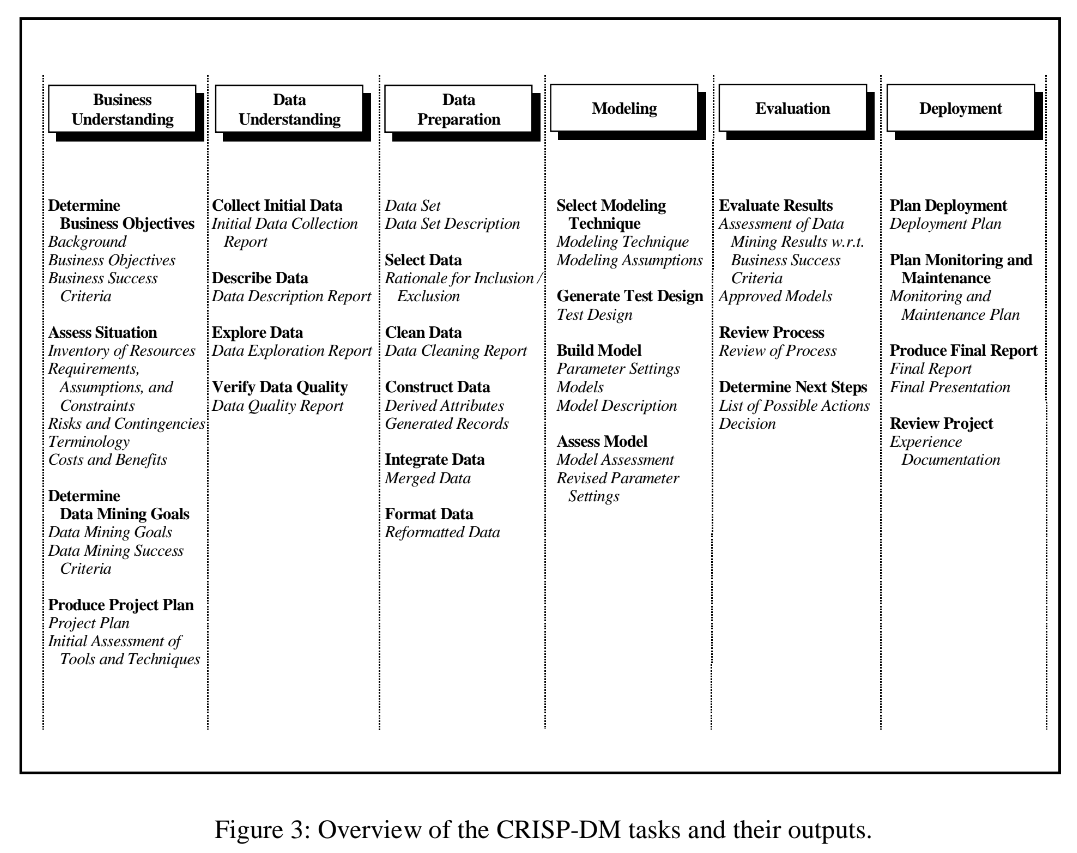

# Imports

In [58]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from itertools import cycle, islice

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
)
from sklearn.compose import (
    make_column_transformer,
    TransformedTargetRegressor,
    make_column_selector,
)
from sklearn.utils import Bunch
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error,
    PredictionErrorDisplay,
    median_absolute_error,
    mean_absolute_error,
    r2_score,
)

from IPython.display import Image

import seaborn as sns

In [59]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (16, 4)})
sns.set()

# Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

>This initial phase focuses on understanding the project objectives and requirements from a business perspective, and then converting this knowledge into a data mining problem definition, and a preliminary project plan designed to achieve the objectives.

## Business Objective

The business objective is to ultimately to run a more profitable used-car dealership
- To do so, they want to know what a given car would likely sell for

## Resource Inventory

The resource inventory is
- A data set from Kaggle containing hundreds of thousands of records of prior car sales

## Data Mining Goals

The data mining goals are
- To determine what features matter when predicting car price
- To select a minimal set which achieves a stated level of accuracy
- To choose a model that when operated against these features is accurate at predicting car prices

## Success Criteria

The success criteria are
- Given a set of features, predict the car price on average within **$3,000**
    - $3000 is madeup, but call it a target for now
    - The error is assessed against the mean absolute error (MAE) over development set

# Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

>The data understanding phase starts with an initial data collection and proceeds with activities in order to get familiar with the data, to identify data quality problems, to discover first insights into the data, or to detect interesting subsets to form hypotheses for hidden information. There is a close link between Business Understanding and Data Understanding. The formulation of the data mining problem and the project plan require at least some understanding of the available data.

## Expected Steps

To get to know the data set, and identify any quality issues with it, I anticipate performing the following steps
- Load the data in and display the first few records
- Check for missing or invalid data
- Make plots of individual features and pair plots to understand what correlates with the target feature

## Data Collection and Description

The collection is a given as it was provided. The data consists of about 425,00 records, each record describes
- Where the car sale was
- For what price it sold
- The vehicle identification number (VIN)
- The year, condition, and mileage of the car
- The make and model

## Data Exploration

- Display some rows
- Check for nulls
- Make some plots
- What correlates with price?

### Data Load

In [60]:
vehicle_file_cropped = "./data/vehicles_no_nulls.csv"
if 0:
    # Read full data set and save a cropped version - no nans
    df = pd.read_csv("./data/vehicles.csv")
    df = df.dropna()
    df.to_csv(vehicle_file_cropped, index=False)

# Read back the smaller table
df = pd.read_csv(vehicle_file_cropped).sample(frac=1.0, random_state=19)

### Display Some Rows, Check Value Ranges, and Null Counts

There are no nulls because I cropped the data set above

In [61]:
df

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
12083,7316155043,fort wayne,54900,2019.0,ram,3500 4x4 cummins,excellent,6 cylinders,diesel,55822.0,clean,automatic,3C7WR9CL5KG517631,4wd,full-size,pickup,black,in
9282,7314820840,south florida,1,2016.0,nissan,370z,excellent,6 cylinders,gas,19141.0,clean,other,JN1AZ4EH6GM937103,rwd,mid-size,coupe,black,fl
28926,7312786878,myrtle beach,0,2012.0,ford,f-250 sd,good,8 cylinders,gas,28256.0,clean,automatic,1FDBF2B61CEC57787,4wd,full-size,truck,custom,sc
18248,7303413468,rochester,9900,2017.0,ford,focus titanium,excellent,4 cylinders,gas,26850.0,salvage,automatic,1FADP3J22HL281300,fwd,compact,sedan,black,mn
9276,7314820999,south florida,1,2019.0,ram,3500,excellent,6 cylinders,gas,48785.0,clean,other,3C63RRHL7KG625247,4wd,full-size,truck,white,fl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33811,7316378796,eau claire,3995,2011.0,ford,fusion,excellent,4 cylinders,gas,207000.0,clean,automatic,3FAHP08A5BR256025,fwd,mid-size,sedan,silver,wi
21416,7313931468,south jersey,13599,2016.0,hyundai,santa fe sport,excellent,4 cylinders,gas,153383.0,clean,automatic,5XYZUDLB7GG321408,4wd,full-size,SUV,black,nj
34146,7314820305,madison,22487,2017.0,ford,transit van,good,6 cylinders,gas,84114.0,clean,automatic,1FTYE1ZM2HKB17885,rwd,mid-size,van,white,wi
17141,7306917244,grand rapids,47990,2014.0,ford,super duty f-550 drw,good,8 cylinders,diesel,39253.0,clean,automatic,1FDUF5HT8EEA80861,4wd,full-size,truck,white,mi


In [62]:
def unique_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    return df.apply(
        lambda x: list(islice(cycle(x.unique()), df.nunique(dropna=False).max()))
    )

In [63]:
unique_dataframe(df).head(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
12083,7316155043,fort wayne,54900,2019.0,ram,3500 4x4 cummins,excellent,6 cylinders,diesel,55822.0,clean,automatic,3C7WR9CL5KG517631,4wd,full-size,pickup,black,in
9282,7314820840,south florida,1,2016.0,nissan,370z,good,8 cylinders,gas,19141.0,salvage,other,JN1AZ4EH6GM937103,rwd,mid-size,coupe,custom,fl
28926,7312786878,myrtle beach,0,2012.0,ford,f-250 sd,like new,4 cylinders,other,28256.0,rebuilt,manual,1FDBF2B61CEC57787,fwd,compact,truck,white,sc
18248,7303413468,rochester,9900,2017.0,pontiac,focus titanium,fair,10 cylinders,hybrid,26850.0,lien,automatic,1FADP3J22HL281300,4wd,sub-compact,sedan,yellow,mn
9276,7314820999,ventura county,22995,2014.0,gmc,3500,new,5 cylinders,electric,48785.0,missing,other,3C63RRHL7KG625247,rwd,full-size,van,silver,ca
4894,7314409838,denver,4995,2008.0,honda,e250 super duty cargo,salvage,other,diesel,65695.0,parts only,manual,1FTNE2EWXEDA13774,fwd,mid-size,SUV,red,co
5763,7315439972,reno / tahoe,5950,2007.0,toyota,torrent,excellent,3 cylinders,gas,221618.0,clean,automatic,2CKDL43F886056750,4wd,compact,other,grey,tx
3431,7315295791,brownsville,12350,2013.0,chevrolet,g6,good,12 cylinders,other,127600.0,salvage,other,1G2ZG57N884113477,rwd,sub-compact,convertible,green,oh
30207,7315499219,parkersburg-marietta,12999,2005.0,mazda,sierra sle 1500,like new,6 cylinders,hybrid,167000.0,rebuilt,manual,1GCECT24LKJH73951,fwd,full-size,bus,blue,nm
24964,7316907208,albuquerque,14995,2010.0,dodge,accord coupe,fair,8 cylinders,electric,69213.0,lien,automatic,1HGCT1B35DA016746,4wd,mid-size,hatchback,brown,wi


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34868 entries, 12083 to 10862
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            34868 non-null  int64  
 1   region        34868 non-null  object 
 2   price         34868 non-null  int64  
 3   year          34868 non-null  float64
 4   manufacturer  34868 non-null  object 
 5   model         34868 non-null  object 
 6   condition     34868 non-null  object 
 7   cylinders     34868 non-null  object 
 8   fuel          34868 non-null  object 
 9   odometer      34868 non-null  float64
 10  title_status  34868 non-null  object 
 11  transmission  34868 non-null  object 
 12  VIN           34868 non-null  object 
 13  drive         34868 non-null  object 
 14  size          34868 non-null  object 
 15  type          34868 non-null  object 
 16  paint_color   34868 non-null  object 
 17  state         34868 non-null  object 
dtypes: float64(2), int64(2), ob

In [65]:
df.isnull().sum()

id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
VIN             0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

In [66]:
df.describe()

,id,price,year,odometer
count,3.486800e+04,34868.000000,34868.000000,3.486800e+04
mean,7.311508e+09,15837.446771,2011.176867,1.073991e+05
std,4.299751e+06,13460.056823,7.162332,9.990878e+04
min,7.301592e+09,0.000000,1905.000000,0.000000e+00
25%,7.308189e+09,6500.000000,2008.000000,6.516400e+04
50%,7.312225e+09,12000.000000,2013.000000,1.040000e+05
75%,7.315136e+09,22003.500000,2016.000000,1.411678e+05
max,7.317099e+09,155000.000000,2022.000000,9.999999e+06


In [67]:
df.value_counts()

id          region                  price  year    manufacturer  model         condition  cylinders    fuel    odometer  title_status  transmission  VIN                drive  size       type    paint_color  state
7301592358  worcester / central MA  8995   2013.0  ford          explorer 4x4  good       6 cylinders  gas     150000.0  clean         automatic     1FM5K8AR8DGA42341  4wd    full-size  SUV     custom       ma       1
7314502778  chattanooga             29900  2019.0  ford          f-150         like new   8 cylinders  gas     23004.0   clean         automatic     1FTMF1C59KKD08613  rwd    full-size  truck   white        tn       1
7314502768  nashville               32900  2019.0  ford          transit       like new   6 cylinders  gas     15294.0   clean         automatic     1FTYR1YM3KKB52304  rwd    full-size  van     white        tn       1
7314502769  knoxville               36700  2019.0  ford          transit       like new   6 cylinders  gas     14985.0   clean       

In [68]:
df.loc[:, df.dtypes == "object"]

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
12083,fort wayne,ram,3500 4x4 cummins,excellent,6 cylinders,diesel,clean,automatic,3C7WR9CL5KG517631,4wd,full-size,pickup,black,in
9282,south florida,nissan,370z,excellent,6 cylinders,gas,clean,other,JN1AZ4EH6GM937103,rwd,mid-size,coupe,black,fl
28926,myrtle beach,ford,f-250 sd,good,8 cylinders,gas,clean,automatic,1FDBF2B61CEC57787,4wd,full-size,truck,custom,sc
18248,rochester,ford,focus titanium,excellent,4 cylinders,gas,salvage,automatic,1FADP3J22HL281300,fwd,compact,sedan,black,mn
9276,south florida,ram,3500,excellent,6 cylinders,gas,clean,other,3C63RRHL7KG625247,4wd,full-size,truck,white,fl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33811,eau claire,ford,fusion,excellent,4 cylinders,gas,clean,automatic,3FAHP08A5BR256025,fwd,mid-size,sedan,silver,wi
21416,south jersey,hyundai,santa fe sport,excellent,4 cylinders,gas,clean,automatic,5XYZUDLB7GG321408,4wd,full-size,SUV,black,nj
34146,madison,ford,transit van,good,6 cylinders,gas,clean,automatic,1FTYE1ZM2HKB17885,rwd,mid-size,van,white,wi
17141,grand rapids,ford,super duty f-550 drw,good,8 cylinders,diesel,clean,automatic,1FDUF5HT8EEA80861,4wd,full-size,truck,white,mi


In [69]:
df.nunique()

id              34868
region            392
price            3136
year               89
manufacturer       41
model            5139
condition           6
cylinders           8
fuel                5
odometer        16689
title_status        6
transmission        3
VIN             21938
drive               3
size                4
type               13
paint_color        12
state              51
dtype: int64

In [70]:
df.loc[:, df.dtypes == "object"].nunique()

region            392
manufacturer       41
model            5139
condition           6
cylinders           8
fuel                5
title_status        6
transmission        3
VIN             21938
drive               3
size                4
type               13
paint_color        12
state              51
dtype: int64

In [71]:
df.loc[:, df.dtypes == "object"].drop(columns=["region", "model", "VIN"]).nunique()

manufacturer    41
condition        6
cylinders        8
fuel             5
title_status     6
transmission     3
drive            3
size             4
type            13
paint_color     12
state           51
dtype: int64

### What Correlates with Price?

Not much of anything :(

In [72]:
df.corr(numeric_only=True)["price"].sort_values(ascending=False)

price       1.000000
year        0.254059
id         -0.049819
odometer   -0.199988
Name: price, dtype: float64

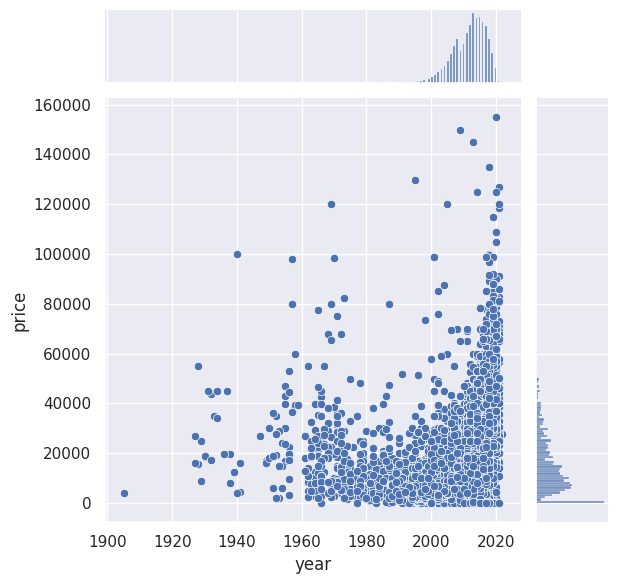

In [73]:
sns.jointplot(df, x="year", y="price")

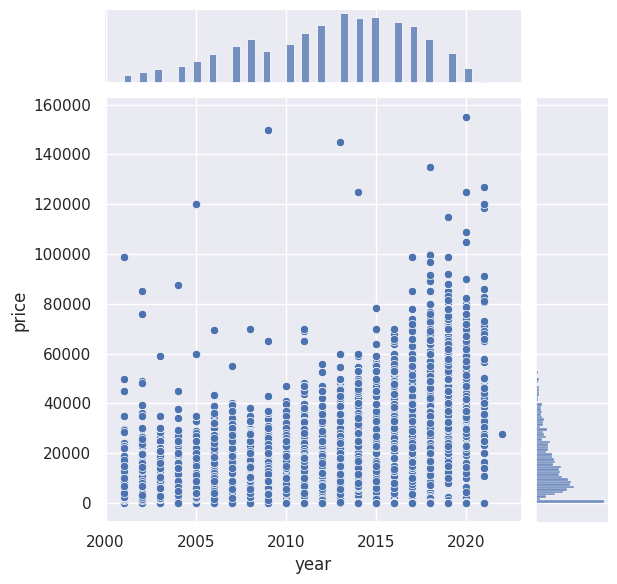

In [74]:
sns.jointplot(df.query("year > 2000"), x="year", y="price")

### Make Some Plots

#### Pair Plots

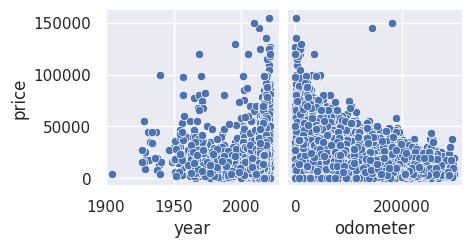

In [75]:
x_vars = ["year", "odometer"]
y_vars = ["price"]
sns.pairplot(df.query("odometer < 300_000"), x_vars=x_vars, y_vars=y_vars)

#### Price

In [76]:
def sns_histplot(data: pd.DataFrame, x: str = ""):
    sns.histplot(
        data=data,
        x=x,
        kde=True,
        palette=sns.color_palette("bright")[:3],
    )

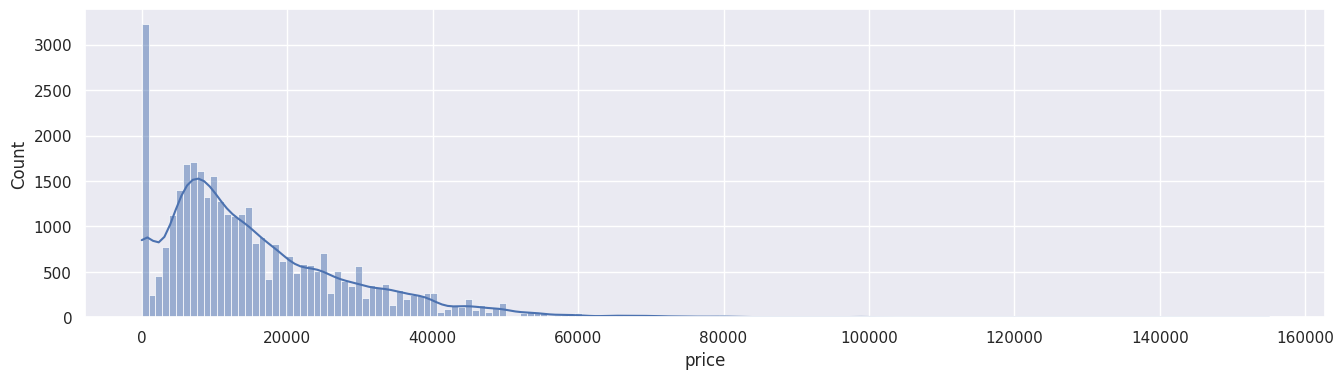

In [77]:
sns_histplot(df, x="price")

In [78]:
df[["price"]].describe()

,price
count,34868.000000
mean,15837.446771
std,13460.056823
min,0.000000
25%,6500.000000
50%,12000.000000
75%,22003.500000
max,155000.000000


In [79]:
[(df["price"] == 0).sum(), (df["price"] > 50000).sum()]

[2372, 669]

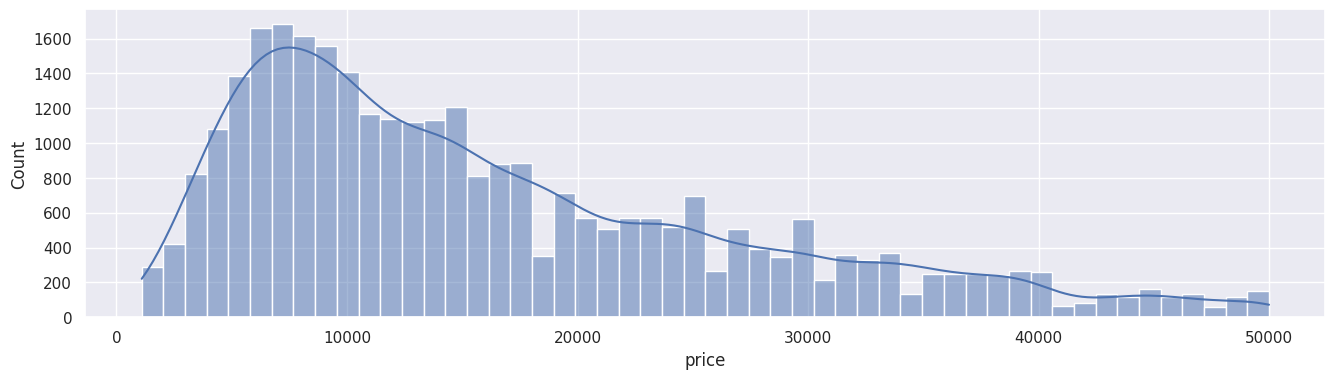

In [80]:
sns_histplot(df.query("price > 1_000 and price < 50000"), x="price")

#### Odomoter

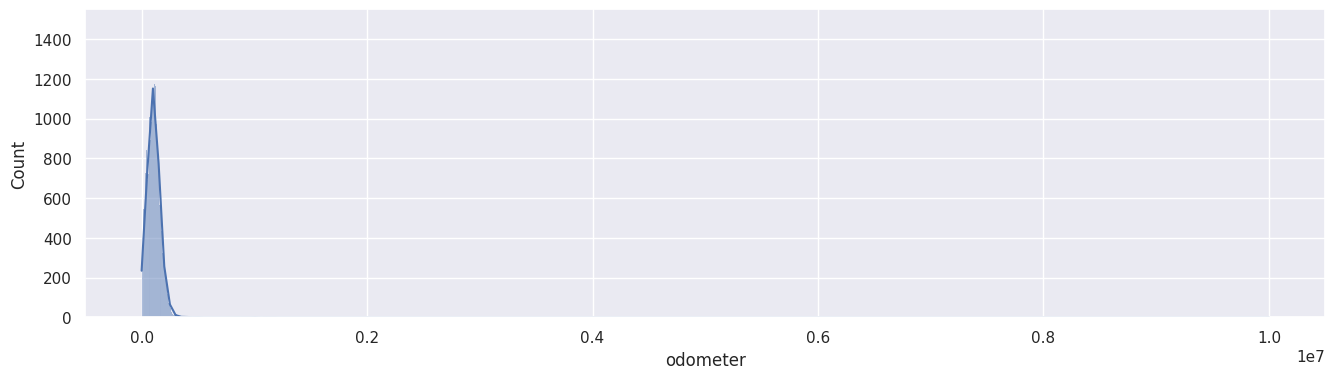

In [81]:
sns_histplot(df, x="odometer")

In [82]:
df[["odometer"]].describe()

,odometer
count,3.486800e+04
mean,1.073991e+05
std,9.990878e+04
min,0.000000e+00
25%,6.516400e+04
50%,1.040000e+05
75%,1.411678e+05
max,9.999999e+06


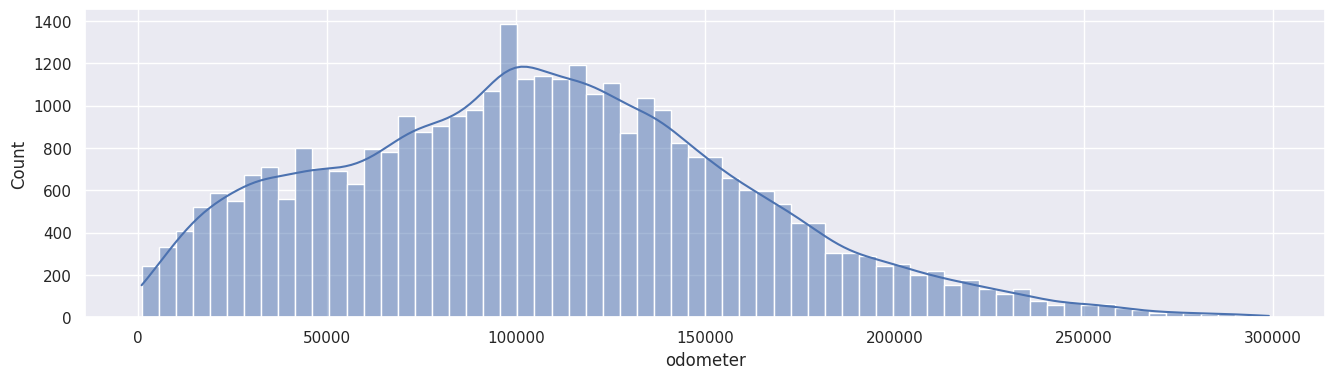

In [83]:
sns_histplot(df[(df["odometer"] > 1000) & (df["odometer"] < 300_000)], x="odometer")

#### Year

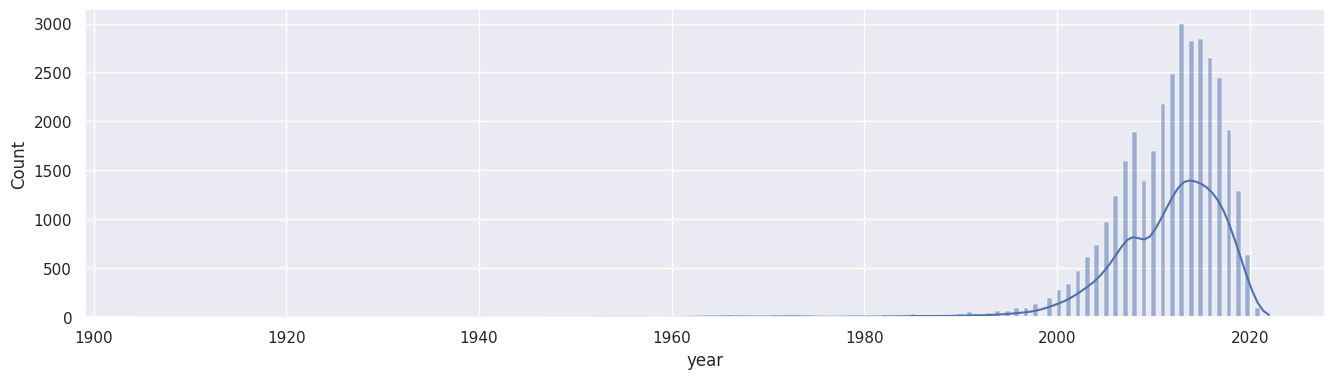

In [84]:
sns_histplot(df, x="year")

In [85]:
df[["year"]].describe()

,year
count,34868.000000
mean,2011.176867
std,7.162332
min,1905.000000
25%,2008.000000
50%,2013.000000
75%,2016.000000
max,2022.000000


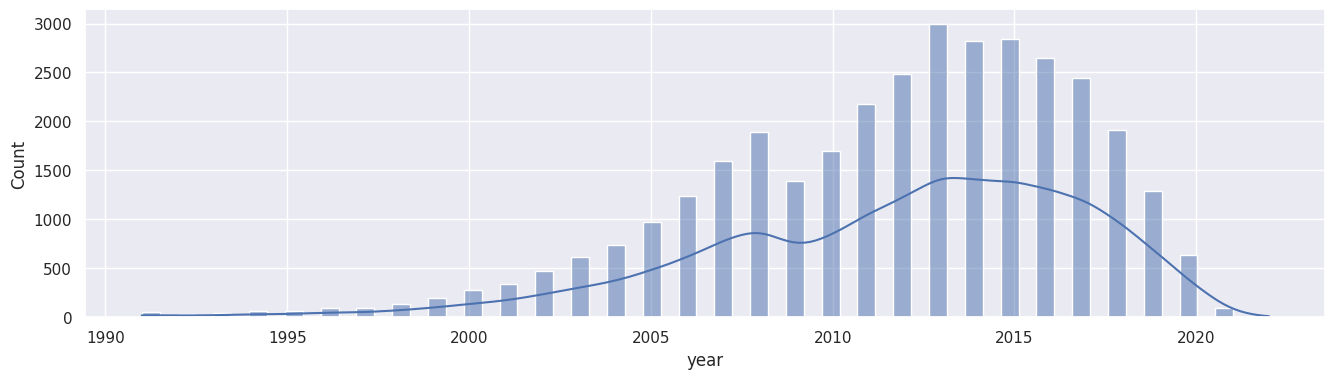

In [86]:
sns_histplot(df[(df["year"] > 1990)], x="year")

### Observations & Adjudications

Such as they are

In [87]:
# Generates the beginnings of a table to copy into markdown
for column in df.columns.to_list():
    print("%s|Keep|" % column)

id|Keep|
region|Keep|
price|Keep|
year|Keep|
manufacturer|Keep|
model|Keep|
condition|Keep|
cylinders|Keep|
fuel|Keep|
odometer|Keep|
title_status|Keep|
transmission|Keep|
VIN|Keep|
drive|Keep|
size|Keep|
type|Keep|
paint_color|Keep|
state|Keep|


#### Drop These

Column|Comments
---|---
id|Junk number
region|High cardinality and redundant given state
model|Too many
VIN|Junk number (although VIN does encode year, manufacturer, other stuff...)
paint_color|I actually think paint color matters, but high cardinality - can it be simplified to popular colors and all else?  

#### Keep These

In [88]:
df["manufacturer"].unique()

array(['ram', 'nissan', 'ford', 'pontiac', 'gmc', 'honda', 'toyota',
       'chevrolet', 'mazda', 'dodge', 'subaru', 'saturn', 'kia',
       'lincoln', 'jeep', 'buick', 'mercedes-benz', 'bmw', 'mercury',
       'chrysler', 'cadillac', 'acura', 'lexus', 'hyundai', 'audi',
       'fiat', 'mini', 'infiniti', 'mitsubishi', 'volvo', 'volkswagen',
       'rover', 'porsche', 'jaguar', 'tesla', 'ferrari', 'datsun',
       'harley-davidson', 'alfa-romeo', 'aston-martin', 'land rover'],
      dtype=object)

In [89]:
df["condition"].unique()

array(['excellent', 'good', 'like new', 'fair', 'new', 'salvage'],
      dtype=object)

Feature|Limit (All are Arbitrary)|Transform
---|---|---
price|1_000, 50_000|Presumed to be bilinear in year and odomoter, plus some other stuff
odometer|1_000, 300_000|Poly
year|>1990|Poly
manufacturer|High cardinality - can collapse into lux and basic and then ordinal?|One hot
condition|None|Ordinal, because excellent > good > salvage

#### Not Sure About These

In [90]:
df["cylinders"].unique()

array(['6 cylinders', '8 cylinders', '4 cylinders', '10 cylinders',
       '5 cylinders', 'other', '3 cylinders', '12 cylinders'],
      dtype=object)

In [91]:
df["title_status"].unique()

array(['clean', 'salvage', 'rebuilt', 'lien', 'missing', 'parts only'],
      dtype=object)

In [92]:
df["state"].unique()

array(['in', 'fl', 'sc', 'mn', 'ca', 'co', 'tx', 'oh', 'nm', 'wi', 'ga',
       'sd', 'pa', 'or', 'vt', 'ok', 'nc', 'ia', 'id', 'ky', 'az', 'ny',
       'va', 'mi', 'tn', 'il', 'me', 'de', 'nv', 'ak', 'nj', 'ar', 'hi',
       'mt', 'wa', 'ri', 'dc', 'ma', 'mo', 'al', 'ks', 'wy', 'ut', 'md',
       'nd', 'nh', 'la', 'wv', 'ct', 'ne', 'ms'], dtype=object)

Feature|Comments
---|---
cylinders|I think this is important but I don't want to deal with it right now
title_status|I think this is important but also correlated with condition. Would be ordinal because clean > rebuilt > salvage
transmission|
drive|
size|
type|
fuel|Does fuel type matter? I bet it does - gas cars >> diesel cars
state|I would guess it is important, but can it be collapsed to major region e.g. coastal and not?

## Verify Data Quality

I think the idea here is to sanity check the data set, perhaps in the event that someone formed an aggregate by pulling from multiple sources
- Can do some range plots checks again and verify something like price makes sense
- But essentially have already done that above
- Also this data set was a given so the criticality is lower... right?

# Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.  

>The data preparation phase covers all activities to construct the final dataset (data that will be fed into the modeling tool(s)) from the initial raw data. Data preparation tasks are likely to be performed multiple times, and not in any prescribed order. Tasks include table, record, and attribute selection, data cleaning, construction of new attributes, and transformation of data for modeling tools.

## Cleaning / Dropping / Deleting

Using the results from the above exploration to reduce the data down by
- Dropping columns
- Dropping rows where values are out of reasonable ranges
- Compressing high-cardinality sets into groups
    - I bet this could be done smartly with kmeans or similar
    - But I'll do it manually for now

### Name the Columns to Keep

In [93]:
target_feature = "price"

numeric_features = [
    "odometer",
    "year",
]

one_hot_features = [
    "manufacturer",
]

ordinal_features = [
    "condition",
]

In [94]:
keep_features = numeric_features + one_hot_features + ordinal_features

### Limits

In [95]:
def limit_mask(data: pd.DataFrame, column: str, a: int, b: int = np.inf):
    # Open / Open interval on a, b
    return data[column].gt(a) & data[column].lt(b)

In [96]:
mask = (
    limit_mask(df, "price", 1_000, 50_000)
    & limit_mask(df, "odometer", 1_000, 300_000)
    & limit_mask(df, "year", 1990)
)

In [97]:
X = df[mask][keep_features]
y = df[mask][target_feature]

In [98]:
X

,odometer,year,manufacturer,condition
18248,26850.0,2017.0,ford,excellent
4894,65695.0,2014.0,ford,excellent
5763,221618.0,2008.0,pontiac,good
3431,127600.0,2008.0,pontiac,excellent
30207,167000.0,2007.0,gmc,like new
...,...,...,...,...
33811,207000.0,2011.0,ford,excellent
21416,153383.0,2016.0,hyundai,excellent
34146,84114.0,2017.0,ford,good
17141,39253.0,2014.0,ford,good


In [99]:
y

18248     9900
4894     22995
5763      4995
3431      5950
30207    12350
         ...  
33811     3995
21416    13599
34146    22487
17141    47990
10862    19995
Name: price, Length: 30110, dtype: int64

### Compressions

Condition is too complicated. Smash several synonymous names together
- Or not. Try as is for now

## Feature Development

In [100]:
X["condition"].unique()

array(['excellent', 'good', 'like new', 'fair', 'new', 'salvage'],
      dtype=object)

In [101]:
condition_categories = [
    "new",
    "like new",
    "excellent",
    "good",
    "fair",
    "salvage",
]

## Data Transformations

Scaling, logs, normalizing

# Modeling

With your almost final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.  

>In this phase, various modeling techniques are selected and applied, and their parameters are calibrated to optimal values. Typically, there are several techniques for the same data mining problem type. Some techniques require specific data formats. There is a close link between Data Preparation and Modeling. Often, one realizes data problems while modeling or one gets ideas for constructing new data.

## Train / Test Split

75/25 is arbitrary

In [102]:
(X_train, X_dev, y_train, y_dev, idx_train, idx_dev) = train_test_split(
    X, y, range(len(X)), random_state=42, train_size=0.75
)

## Model-Agnostic Helpers

In [103]:
def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "Mean AE": round(mean_absolute_error(y_true, y_pred)),
        "RMSE": round(root_mean_squared_error(y_true, y_pred)),
    }

The following is adapted from [this example](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py)

In [104]:
def make_PredictionErrorDisplay_plot(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_dev: pd.DataFrame,
    y_dev: pd.Series,
    model: any,
    description: str = "",
):
    f, ax = plt.subplots(2, 2, sharex=True, figsize=(16, 10))

    for k in range(2):
        ax_row = ax[k]
        if k == 0:
            y_true, y_pred = y_train, model.predict(X_train[model.feature_names_in_])
        else:
            y_true, y_pred = y_dev, model.predict(X_dev[model.feature_names_in_])

        # Plot the actual vs predicted values
        PredictionErrorDisplay.from_predictions(
            y_true,
            y_pred,
            kind="actual_vs_predicted",
            ax=ax_row[0],
            scatter_kwargs={"alpha": 0.5},
        )

        ax_row[0].set_title(
            "%s Actual vs. Predicted\nErrors: %s"
            % ("Train" if k == 0 else "Dev", str(compute_score(y_true, y_pred)))
        )

        # plot the residuals vs the predicted values
        PredictionErrorDisplay.from_predictions(
            y_true,
            y_pred,
            kind="residual_vs_predicted",
            ax=ax_row[1],
            scatter_kwargs={"alpha": 0.5},
        )

        ax_row[1].set_title(
            "%s Residual vs. Predicted" % ("Train" if k == 0 else "Dev")
        )

    plt.suptitle(
        description,
        fontsize=16,
        fontweight="bold",
        ha="center",
    )

    plt.tight_layout()
    plt.show()

## Model 1 - Establish a Baseline

Attributes
- Linear regression in year and odometer
- No optimization

### Define

#### Poly Features

In [105]:
poly_features = ["year", "odometer"]
poly_pipe = Pipeline(
    [
        (
            "scaler",
            make_column_transformer(
                (
                    StandardScaler(),
                    poly_features,
                ),
            ),
        ),
        (
            "poly",
            PolynomialFeatures(degree=1, include_bias=False),
        ),
    ]
)

poly_pipe

Pipeline(steps=[('scaler',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['year', 'odometer'])])),
                ('poly', PolynomialFeatures(degree=1, include_bias=False))])

In [106]:
if 0:
    poly_pipe.fit(X)
    display(
        pd.DataFrame(
            poly_pipe.transform(X[poly_features]),
            columns=poly_pipe.get_feature_names_out(),
        )
    )

#### Pipeline

In [107]:
baseline_model_features = poly_features
baseline_model = Pipeline(
    [
        ("transform", poly_pipe),
        ("regression", LinearRegression(fit_intercept=True)),
    ]
).fit(X_train[baseline_model_features], y_train)
baseline_model

Pipeline(steps=[('transform',
                 Pipeline(steps=[('scaler',
                                  ColumnTransformer(transformers=[('standardscaler',
                                                                   StandardScaler(),
                                                                   ['year',
                                                                    'odometer'])])),
                                 ('poly',
                                  PolynomialFeatures(degree=1,
                                                     include_bias=False))])),
                ('regression', LinearRegression())])

### Plot

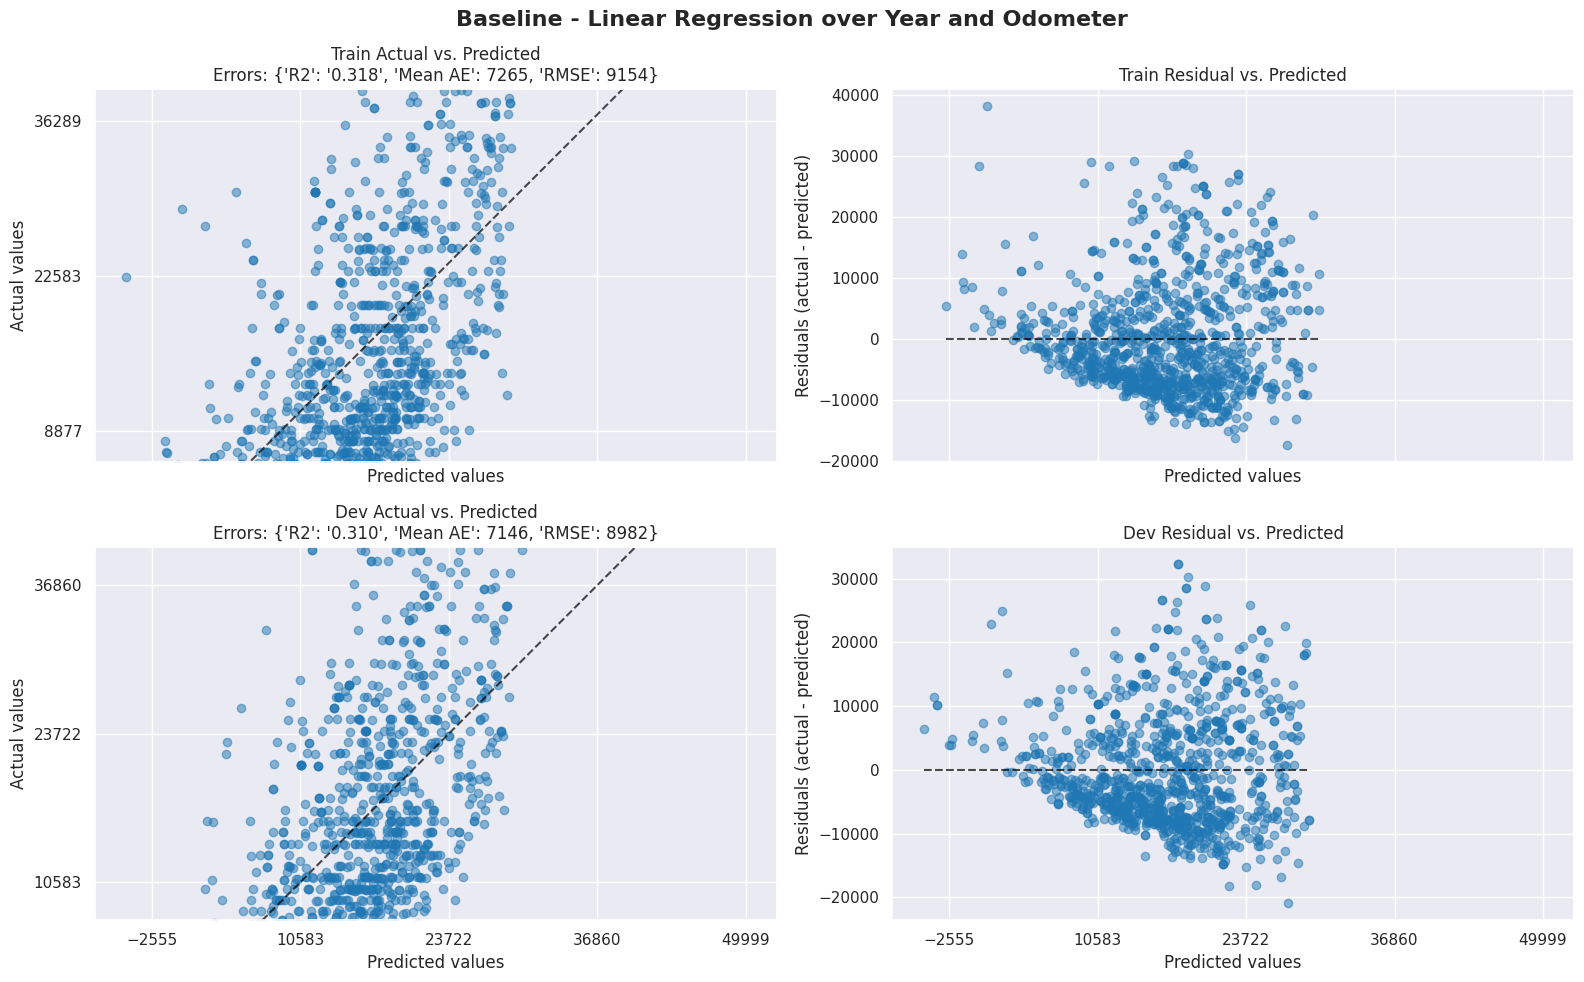

In [118]:
make_PredictionErrorDisplay_plot(
    X_train,
    y_train,
    X_dev,
    y_dev,
    baseline_model,
    description="Baseline - Linear Regression over Year and Odometer",
)

### Analysis

The baseline model is pretty terrible. The error is more than 2x the requirement.

## Model 2 - Getting Fancy

Attributes
- Regressor is ridge
- Features are poly, ordinal, and one hot
- Scaling is applied on the transformed features (inputs to ridge) to avoid crushing large values
- Hyperparameter search with grid

### Define

#### Categorical Features

One hot and ordinals

In [109]:
categorical_features = one_hot_features + ordinal_features
categorical_xformer = make_column_transformer(
    (
        OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="ignore"),
        one_hot_features,
    ),
    (OrdinalEncoder(categories=[condition_categories]), ordinal_features),
)

In [110]:
if 0:
    categorical_xformer.fit(X)
    display(
        pd.DataFrame(
            categorical_xformer.transform(X[categorical_features]),
            columns=categorical_xformer.get_feature_names_out(),
        )
    )

#### Feature Union

In [111]:
feature_union = FeatureUnion(
    [
        ("poly_pipe", poly_pipe),
        ("categorical_xformer", categorical_xformer),
    ]
)

feature_union

FeatureUnion(transformer_list=[('poly_pipe',
                                Pipeline(steps=[('scaler',
                                                 ColumnTransformer(transformers=[('standardscaler',
                                                                                  StandardScaler(),
                                                                                  ['year',
                                                                                   'odometer'])])),
                                                ('poly',
                                                 PolynomialFeatures(degree=1,
                                                                    include_bias=False))])),
                               ('categorical_xformer',
                                ColumnTransformer(transformers=[('onehotencoder',
                                                                 OneHotEncoder(drop='if_binary',
                                                                               handle_unknown='ignore',
                                                                               sparse_output=False),
                                                                 ['manufacturer']),
                                                                ('ordinalencoder',
                                                                 OrdinalEncoder(categories=[['new',
                                                                                             'like '
                                                                                             'new',
                                                                                             'excellent',
                                                                                             'good',
                                                                                             'fair',
                                                                                             'salvage']]),
                                                                 ['condition'])]))])

In [112]:
if 0:
    feature_union.fit(X)
    display(
        pd.DataFrame(
            feature_union.transform(X[ridge_model_features]),
            columns=feature_union.get_feature_names_out(),
        )
    )

#### Pipeline

In [113]:
ridge_model_features = poly_features + categorical_features
ridge_model = Pipeline(
    [
        ("feature_union", feature_union),
        ("scaler", StandardScaler()),
        ("ridge", Ridge(fit_intercept=True)),
    ]
).fit(X_train[ridge_model_features], y_train)
ridge_model

Pipeline(steps=[('feature_union',
                 FeatureUnion(transformer_list=[('poly_pipe',
                                                 Pipeline(steps=[('scaler',
                                                                  ColumnTransformer(transformers=[('standardscaler',
                                                                                                   StandardScaler(),
                                                                                                   ['year',
                                                                                                    'odometer'])])),
                                                                 ('poly',
                                                                  PolynomialFeatures(degree=1,
                                                                                     include_bias=False))])),
                                                ('categorical_xformer',
                                                 ColumnTransformer(transformers=[('onehotencoder',
                                                                                  OneHotEncoder(drop='if_binary',
                                                                                                handle_unknown='ignore',
                                                                                                sparse_output=False),
                                                                                  ['manufacturer']),
                                                                                 ('ordinalencoder',
                                                                                  OrdinalEncoder(categories=[['new',
                                                                                                              'like '
                                                                                                              'new',
                                                                                                              'excellent',
                                                                                                              'good',
                                                                                                              'fair',
                                                                                                              'salvage']]),
                                                                                  ['condition'])]))])),
                ('scaler', StandardScaler()), ('ridge', Ridge())])

### Plot

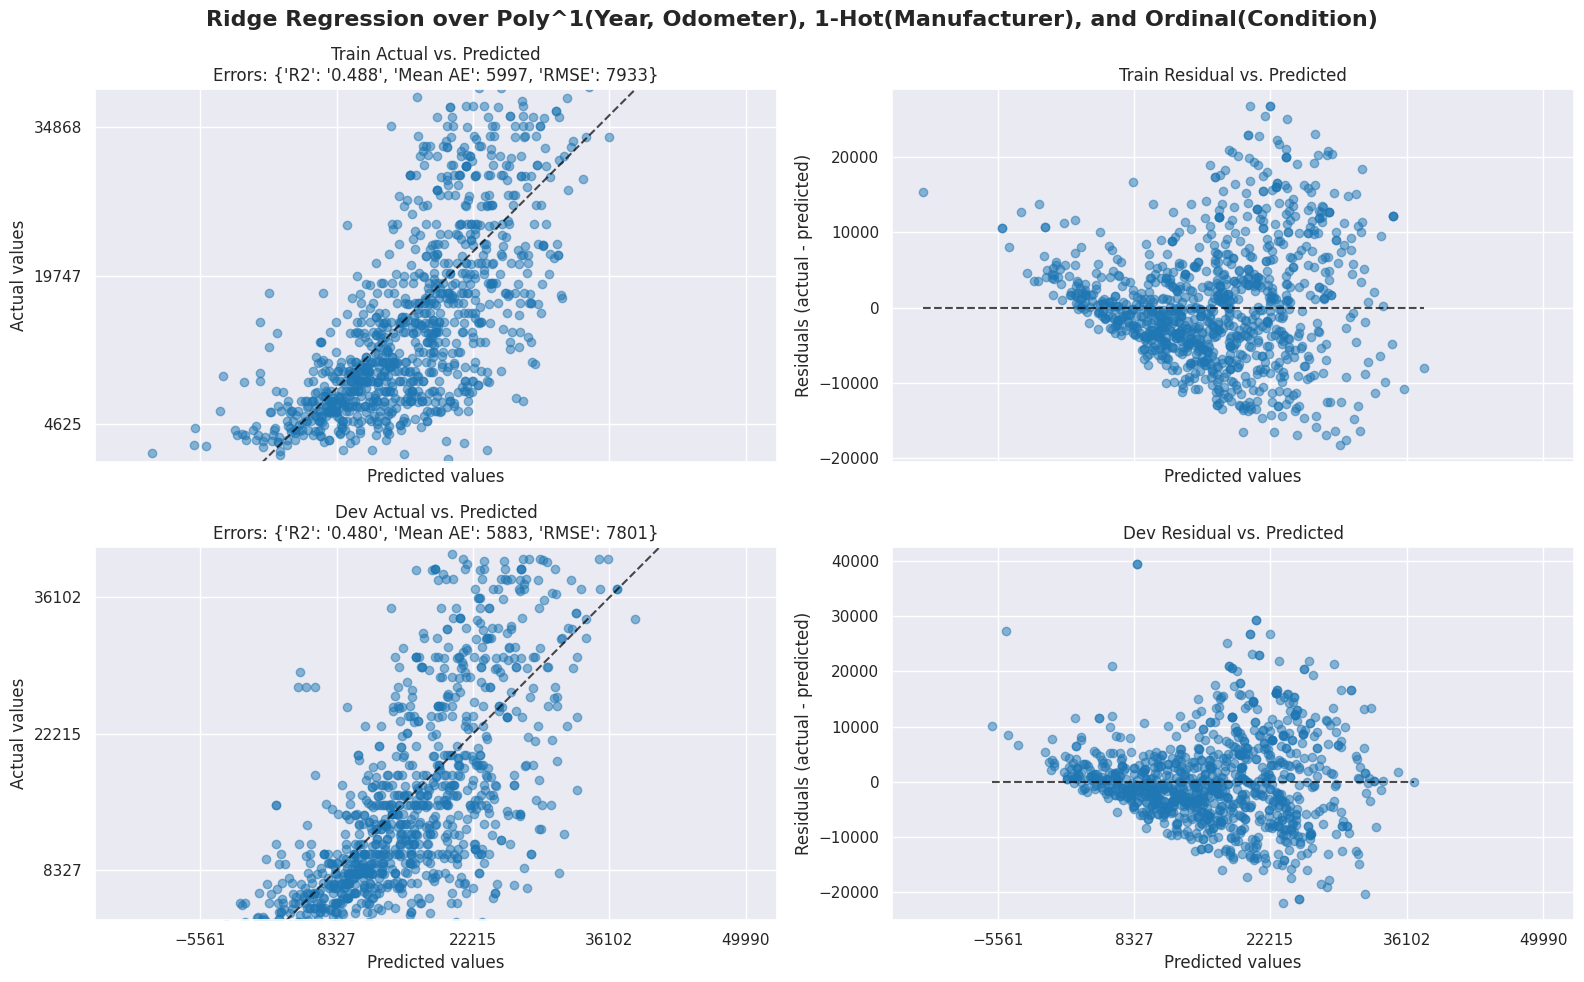

In [119]:
make_PredictionErrorDisplay_plot(
    X_train,
    y_train,
    X_dev,
    y_dev,
    ridge_model,
    description="Ridge Regression over Poly^1(Year, Odometer), 1-Hot(Manufacturer), and Ordinal(Condition)",
)

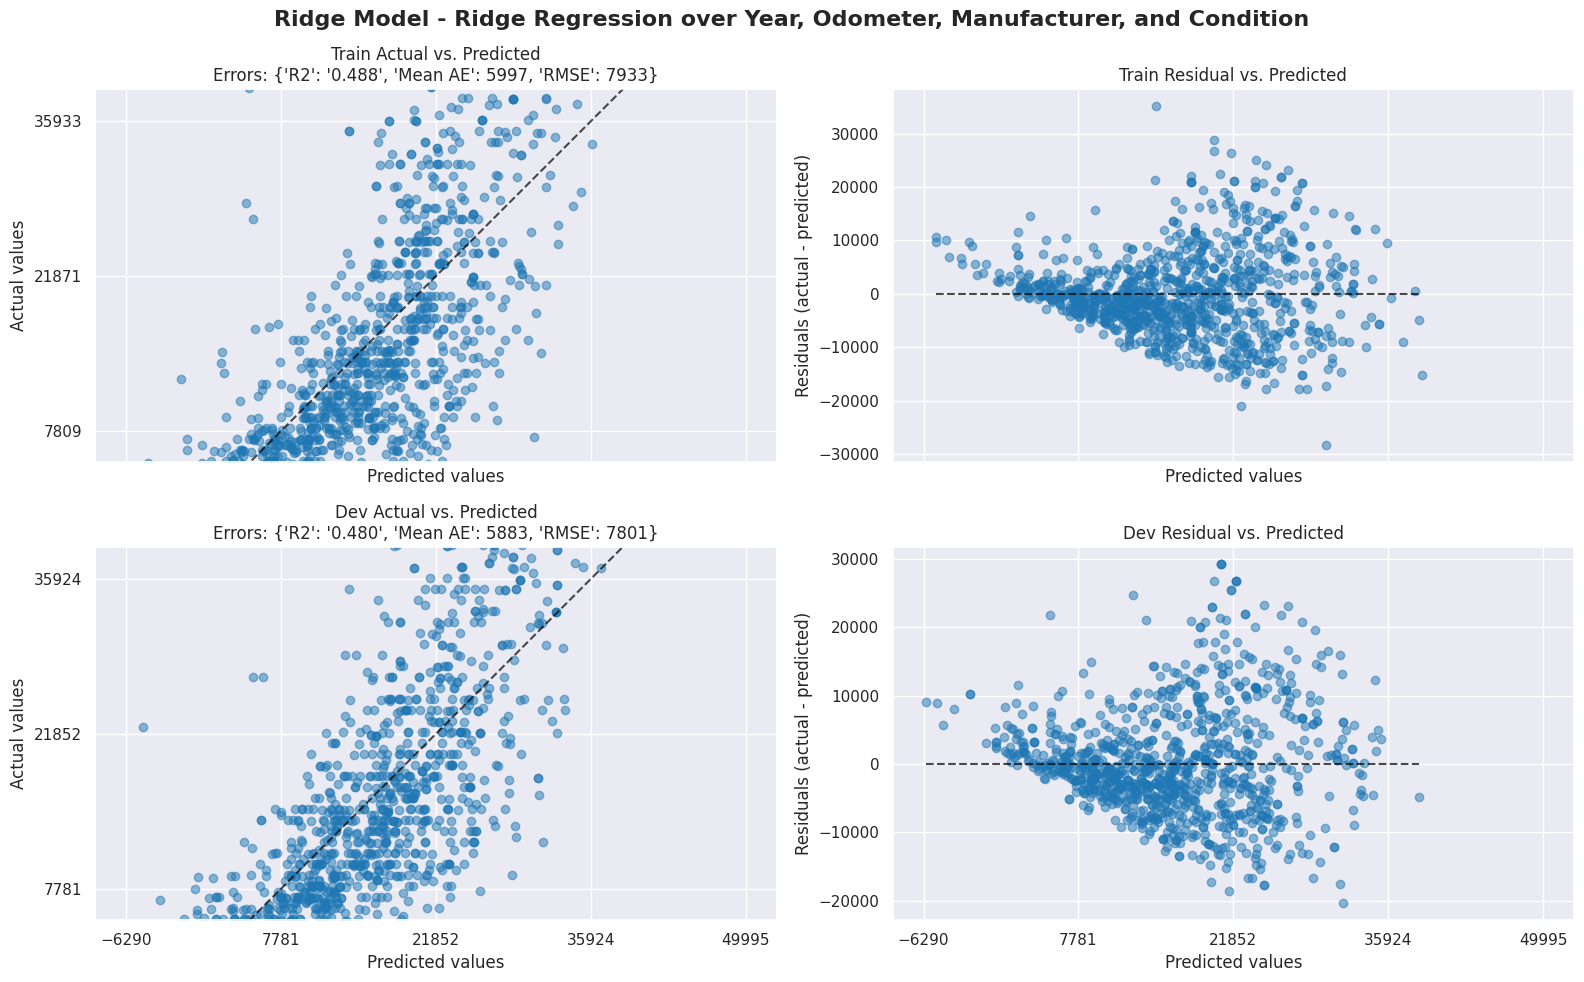

### Analysis

The ridge model with no optimization is looking better than baseline, but is not good enough.

## Model 3 - Slim it Down

Attributes
- Regressor is ridge
- Features are poly, ordinal, and one hot
    - But are shrunk down to **N** with RFE
    - What should **N** be?
- Hyperparameter search with grid

# Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

>At this stage in the project you have built one or more models that appear to have high quality, from a data analysis perspective. Before proceeding to final deployment of the model, it is important to more thoroughly evaluate the model, and review the steps executed to construct the model, to be certain it properly achieves the business objectives. A key objective is to determine if there is some important business issue that has not been sufficiently considered. At the end of this phase, a decision on the use of the data mining results should be reached.

# Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

>Creation of the model is generally not the end of the project. Usually, the knowledge gained will need to be organized and presented in a way that the customer can use it. Depending on the requirements, the deployment phase can be as simple as generating a report or as complex as implementing a repeatable data mining process. In many cases it will be the user, not the data analyst, who will carry out the deployment steps. In any case, it is important to understand up front what actions will need to be carried out in order to actually make use of the created models.